# Guessing game

Loosely following Lazaridou et al. (2017).

In [1]:
import importlib

import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.disable_eager_execution()

In [34]:
# IMG_EMB_FILE = "data/vgg19-10000.emb.gz"
IMG_EMB_FILE = "data/xception-10000.emb.gz"
N_SYMBOLS = 50
N_IMAGES = 100
N_CHOICES = 2
EMB_SIZE = 50

In [35]:
from tools.tools import load_emb_gz
_, fnames, embs = load_emb_gz(IMG_EMB_FILE, N_IMAGES)
fnames = fnames
embs = embs
IMG_SHAPE = embs[0].shape
IMG_N = len(embs)
IMG_SHAPE, IMG_N

DONE. 100 items loaded from data/xception-10000.emb.gz.


((1000,), 100)

In [31]:
def smooth_avg(old, new, new_weight=1):
    if old is None:
        return new
    return (old + new * new_weight)/(1 + new_weight)

## Set up model

In [87]:
import game.game as game
import agent.pg_agent as agent
from keras.optimizers import Adam, SGD, Adagrad, Nadam
importlib.reload(agent)
importlib.reload(game)

sender = agent.Sender(input_sizes=[IMG_SHAPE, IMG_SHAPE], 
                      output_size=N_SYMBOLS, 
                      n_symbols=N_SYMBOLS,
                      embedding_size=50, 
                      learning_rate=0.001, 
                      gibbs_temp=10,
                      use_bias=True,
                      optimizer=Adam)
receiver = agent.Receiver(input_sizes=[IMG_SHAPE, IMG_SHAPE, (1,)], 
                        output_size=N_CHOICES, 
                        n_symbols=N_SYMBOLS,
                        embedding_size=50, 
                        learning_rate=0.001, 
                        gibbs_temp=10,
                        mode="dot", # original with dot product output
                        #mode="dense", # dense layer + sigmoid instead
                        use_bias=True,
                        optimizer=Adam)
g = game.Game(images=embs, 
              images_filenames=fnames, 
              sender=sender, 
              receiver=receiver,
              reward={"success": 1, "fail": 0})
#sender.model.summary()
#receiver.train_model.summary()

<IPython.core.display.Javascript object>


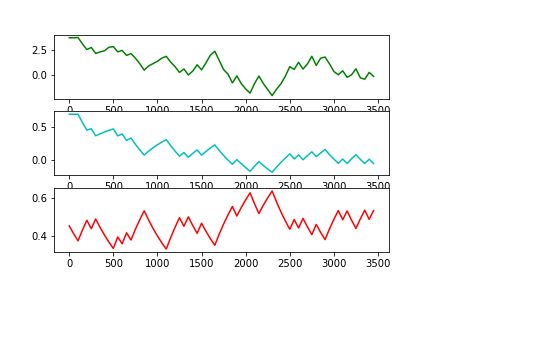

KeyboardInterrupt: 

In [88]:
fig = plt.figure()
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
plt.ion()

fig.show()
fig.canvas.draw()

t = []
show_steps = 2500
success_rate = []
sendr_loss = []
recvr_loss = []
success_rate_avg = 0.5
sendr_loss_avg = None
recvr_loss_avg = None
for i in range(10000):
    success = g.take_turn()
    if not i % 50:
        t.append(i)
        success_rate_avg = smooth_avg(success_rate_avg, success, 0.1)
        sendr_loss_avg = smooth_avg(sendr_loss_avg, sender.last_loss, 0.1)
        recvr_loss_avg = smooth_avg(recvr_loss_avg, receiver.last_loss, 0.1)
        success_rate.append(success_rate_avg)
        sendr_loss.append(sendr_loss_avg)
        recvr_loss.append(recvr_loss_avg)
#     print(success, sender.last_loss, receiver.last_loss)
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax1.plot(t[-show_steps:], sendr_loss[-show_steps:], "g")
        ax2.plot(t[-show_steps:], recvr_loss[-show_steps:], "c")
        ax3.plot(t[-show_steps:], success_rate[-show_steps:], "r")
        fig.canvas.draw()

In [ ]:
sender.save("sender.weights")
receiver.save("receiver.weights")


In [ ]:
sender.load("sender.weights")
receiver.load("receiver.weights")
